# Identify cause of convection by trying to apply FW where too much dense water forms off the shelf

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import glob
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.grid import region_mask

In [3]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

In [18]:
ds_coast = xr.open_dataset(f'{base_dir}bathymetry/distance_coast-20250715.nc')
ds_berg  = xr.open_dataset(f'{base_dir}misc-forcing/AntArc_eORCA025_bergmelt.nc')
ds_runoff = xr.open_dataset(f'{base_dir}misc-forcing/AntArc_eORCA025_runoff_b0.2_v0.0_nohls.nc')
mesh_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250715.nc').squeeze().isel(nav_lev=0)

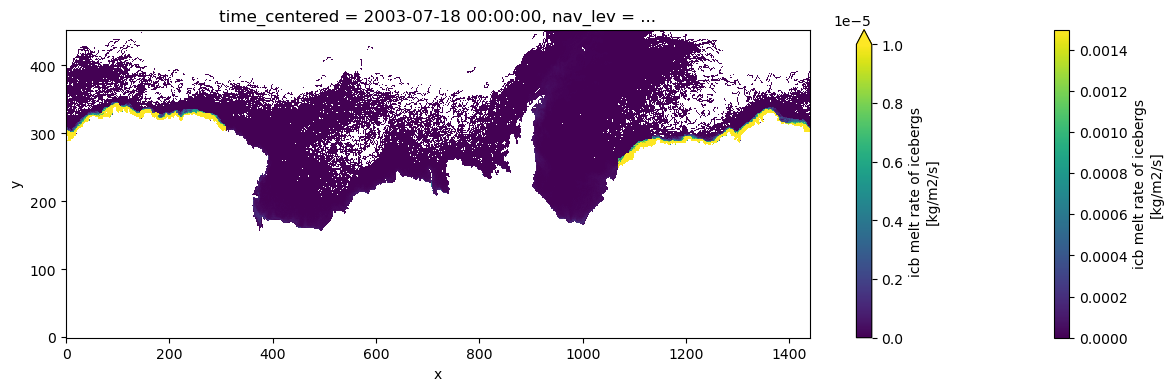

In [33]:
runoff_mask = (ds_coast.distance_coast < 100)*(mesh_mask.nav_lat < -59)*(mesh_mask.nav_lon < 150)*(mesh_mask.nav_lon > -20)

fig, ax = plt.subplots(1,1, figsize=(15,4))
ds_berg.isel(time_counter=0).berg_melt.plot(ax=ax)
ds_berg.isel(time_counter=0).berg_melt.where(runoff_mask).plot(ax=ax, vmin=0, vmax=1e-5)

In [35]:
ds_runoff_new = ds_runoff.copy()

In [59]:
ds_runoff_new = ds_runoff.copy()
runoff_new   = xr.where(runoff_mask, ds_berg.berg_melt*10, 0).drop_vars(['nav_lon','nav_lat'])
runoff_new   = xr.where(np.isnan(runoff_new), 0, runoff_new)
runoff_mouth = xr.where(runoff_new.sum(dim='time_counter')!=0, 1, 0)
ds_runoff_new['sorunoff'] = runoff_new
ds_runoff_new['socoefr']  = runoff_mouth

In [67]:
ds_berg_new = ds_berg.copy()
runoff_new   = xr.where(runoff_mask, ds_berg.berg_melt*10, 0).drop_vars(['nav_lon','nav_lat'])
runoff_new   = xr.where(np.isnan(runoff_new), 0, runoff_new)
ds_berg_new['berg_melt'] = runoff_new.transpose('time_counter','y','x')

In [69]:
ds_berg_new

<xarray.Dataset> Size: 37MB
Dimensions:        (y: 453, x: 1440, time_counter: 12)
Coordinates:
    nav_lat        (y, x) float32 3MB -1.0 -1.0 -1.0 ... -50.06 -50.06 -50.06
    nav_lon        (y, x) float32 3MB -1.0 -1.0 -1.0 -1.0 ... 72.25 72.5 72.75
    time_centered  (time_counter) object 96B 2003-07-18 00:00:00 ... 2004-06-...
  * time_counter   (time_counter) object 96B 2003-07-18 00:00:00 ... 2004-06-...
    nav_lev        float32 4B 0.4921
Dimensions without coordinates: y, x
Data variables:
    berg_melt      (time_counter, y, x) float32 31MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [70]:
ds_berg_new.to_netcdf(f'{base_dir}misc-forcing/AntArc_eORCA025_increased_bergmelt_EAnt.nc', unlimited_dims='time_counter')

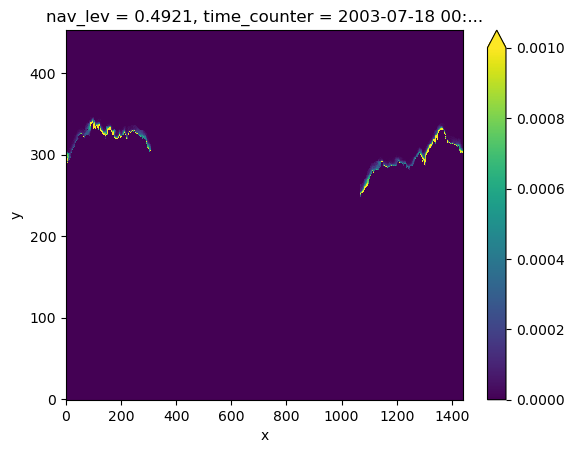

In [47]:
runoff_new.isel(time_counter=0).plot(vmin=0, vmax=1e-3)